## Interpretation & Limitations

- These descriptive statistics reflect **documented** incidents and reports in the snapshot, not the full universe of real-world AI harms.
- Taxonomy coverage differs substantially (MIT > GMF/CSET), so deeper classifications may not be representative of all incidents.
- Report corpus concentration (source domains) can reflect editorial and monitoring biases, not only incident prevalence.

These outputs are intended for transparent, reproducible trend exploration and responsible interpretation.

In [2]:
from IPython.display import display
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

DATA = Path("../data")
OUT = Path("../outputs/figures")
OUT.mkdir(parents=True, exist_ok=True)

gmf = pd.read_csv(DATA / "classifications_GMF.csv")
inc = pd.read_csv(DATA / "incidents.csv")

gmf.columns = [c.strip().lower() for c in gmf.columns]
inc.columns = [c.strip().lower() for c in inc.columns]

# normalize incident id column
if "incident id" in gmf.columns and "incident_id" not in gmf.columns:
    gmf = gmf.rename(columns={"incident id": "incident_id"})

print("GMF:", gmf.shape)
print("Incidents:", inc.shape)

def savefig(fig, name):
    fig.savefig(OUT / name, bbox_inches="tight", dpi=200)

def barh_top(series, title, xlabel, fname, topn=15):
    vc = series.dropna().astype(str).value_counts().head(topn).sort_values()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    vc.plot(kind="barh", ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    savefig(fig, fname)
    plt.show()
    return vc

def barh_percent(series, title, fname):
    pct = (series.dropna().astype(str).value_counts(normalize=True) * 100).round(1).sort_values()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    pct.plot(kind="barh", ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Percent")
    savefig(fig, fname)
    plt.show()
    return pct

GMF: (326, 21)
Incidents: (1367, 9)


In [11]:

def pick_col_by_keywords(df, must_have_keywords, nice_to_have=None):
    nice_to_have = nice_to_have or []
    candidates = []
    for c in df.columns:
        cl = c.lower()
        if all(k in cl for k in must_have_keywords):
            score = sum(1 for k in nice_to_have if k in cl)
            non_null = df[c].notna().sum()
            candidates.append((score, non_null, c))
    if not candidates:
        return None
    return sorted(candidates, reverse=True)[0][2]

failure_col = pick_col_by_keywords(gmf, ["failure"], nice_to_have=["technical", "known", "ai"])
goal_col    = pick_col_by_keywords(gmf, ["goal"], nice_to_have=["known", "ai"])
tech_col    = pick_col_by_keywords(gmf, ["technology"], nice_to_have=["known", "ai"])

print("Chosen failure column:", failure_col)
print("Chosen goal column:", goal_col)
print("Chosen technology column:", tech_col)

if failure_col is None:
    print("No failure-like column found. Candidates containing 'fail':", [c for c in gmf.columns if "fail" in c])
else:
    if gmf[failure_col].dropna().empty:
        print(f"Warning: {failure_col} exists but is entirely null in this snapshot.")
    print("Distinct failure labels:", gmf[failure_col].nunique(dropna=True))
    print("Top 5 failure labels:", gmf[failure_col].dropna().astype(str).value_counts().head(5).to_dict())

Chosen failure column: known ai technical failure snippets
Chosen goal column: known ai goal
Chosen technology column: known ai technology snippets
Distinct failure labels: 282
Top 5 failure labels: {'Snippet Text: \n': 2, 'Snippet Text: \nPart of YouTube’s plan is to increase human moderation and tweak its algorithm, “training machine-learning technology across other challenging content areas, including child safety and hate speech.” YouTube will also cut down on channels that receive monetization and advertisements attached to these videos. Since YouTube Kids also includes ads — many of which, Golin says, aren’t child appropriate — this will affect channels and videos on the platform.\nRelated Classifications: Tuning Issues\n, Snippet Text: "Recommendations are designed to optimize watch time, there is no reason that it shows content that is actually good for kids. \nRelated Classifications: Tuning Issues\n, Snippet Text: On YouTube today, children are being exploited for money. YouT

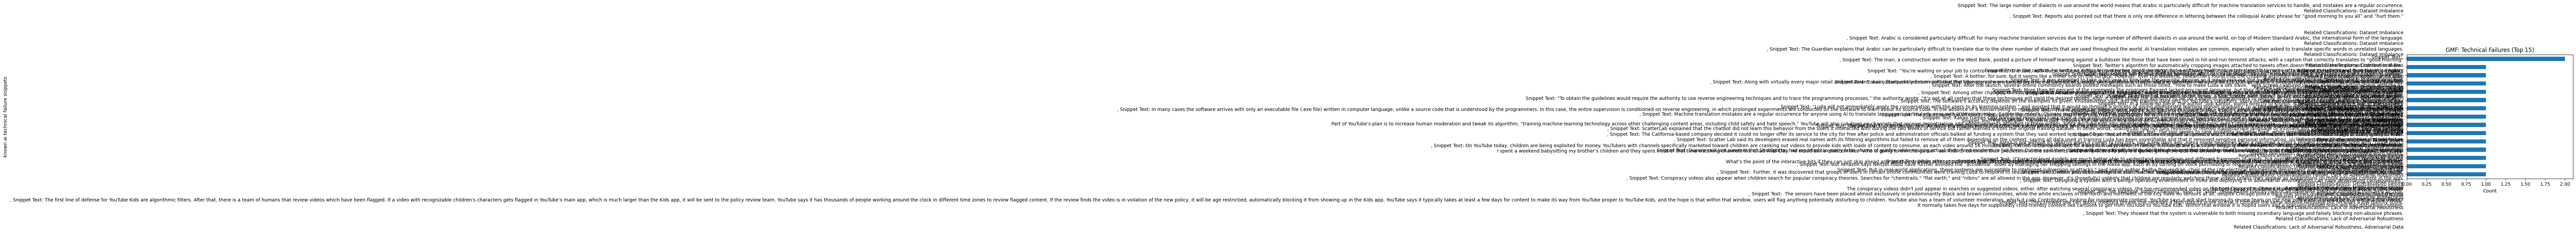

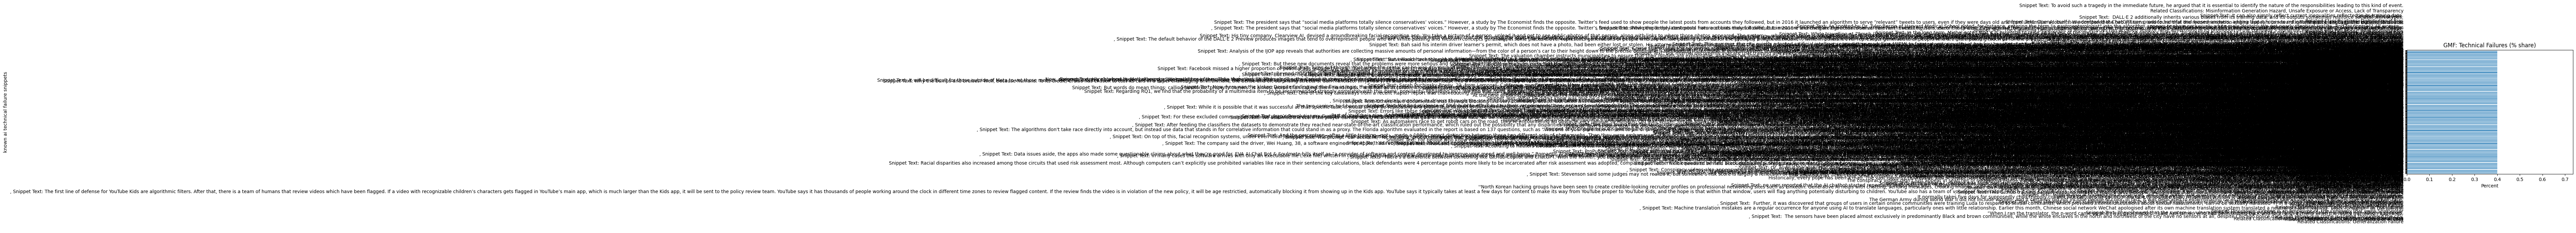

In [10]:
if failure_col is None:
    print("Cannot proceed: GMF failure column not found.")
else:
    barh_top(gmf[failure_col], "GMF: Technical Failures (Top 15)", "Count", "60_gmf_failures_top15.png", 15)
    barh_percent(gmf[failure_col], "GMF: Technical Failures (% share)", "61_gmf_failures_percent.png")
    


In [5]:
if failure_col and goal_col:
    # Keep only rows where both are present
    df = gmf.dropna(subset=[failure_col, goal_col]).copy()
    df[failure_col] = df[failure_col].astype(str)
    df[goal_col] = df[goal_col].astype(str)

    # Most common goals
    top_goals = df[goal_col].value_counts().head(8).index
    df = df[df[goal_col].isin(top_goals)]

    # Crosstab: % within goal
    ct = pd.crosstab(df[goal_col], df[failure_col], normalize="index")
    ct_pct = (ct * 100).round(1)

    print("Failures by Goal (% within goal):")
    display(ct_pct.iloc[:, :10])  # display first few columns if many

else:
    print("Skipping Failures-by-Goal: missing goal or failure column.")

Failures by Goal (% within goal):


known ai technical failure snippets,"Snippet Text: \nPart of YouTube’s plan is to increase human moderation and tweak its algorithm, “training machine-learning technology across other challenging content areas, including child safety and hate speech.” YouTube will also cut down on channels that receive monetization and advertisements attached to these videos. Since YouTube Kids also includes ads — many of which, Golin says, aren’t child appropriate — this will affect channels and videos on the platform.\nRelated Classifications: Tuning Issues\n, Snippet Text: ""Recommendations are designed to optimize watch time, there is no reason that it shows content that is actually good for kids. \nRelated Classifications: Tuning Issues\n, Snippet Text: On YouTube today, children are being exploited for money. YouTubers with channels specifically marketed toward children are cranking out videos to provide kids with loads of content to consume, as each video around 16 minutes long. (Which is the sweet spot for maximum ad revenue.) Frankly, YouTubers are practically begging their viewers to “smash” that like button and comment on their videos.\nI spent a weekend babysitting my brother’s children and they spent most of that time watching channels like Chad Wild Clay. He would ask a question like, “Who is going to win this game?” ask kids to comment their predictions in the comments and then proceed to play the game, giving the kids the answer in the same video. He’d do that same thing several times throughout the video.\n\nWhat’s the point of the interactive bits if they can just skip ahead and get their answers without commenting at all? It’s simple: the more engagement the video gets, the more likely it is to be picked up by YouTube’s recommendation algorithm, thus bringing in more traffic and more money.\nRelated Classifications: Tuning Issues\nSnippet Discussion: Recommendation training / video ranking is utilizing likes and engagement too much.\n, Snippet Text: Conspiracy videos also appear when children search for popular conspiracy theories. Searches for ""chemtrails,"" ""flat earth,"" and ""nibiru"" are all allowed in the app. However, it's (hopefully) unlikely that children are regularly watching these videos unless they appear as suggestions on more popular content in the app.\n\nThe conspiracy videos didn't just appear in searches or suggested videos, either. After watching several conspiracy videos, the top recommended video on the home page of YouTube Kids was a conspiracy theory about aliens on the moon:\nRelated Classifications: Tuning Issues\n, Snippet Text: The first line of defense for YouTube Kids are algorithmic filters. After that, there is a team of humans that review videos which have been flagged. If a video with recognizable children’s characters gets flagged in YouTube’s main app, which is much larger than the Kids app, it will be sent to the policy review team. YouTube says it has thousands of people working around the clock in different time zones to review flagged content. If the review finds the video is in violation of the new policy, it will be age restrictied, automatically blocking it from showing up in the Kids app. YouTube says it typically takes at least a few days for content to make its way from YouTube proper to YouTube Kids, and the hope is that within that window, users will flag anything potentially disturbing to children. YouTube also has a team of volunteer moderators, which it calls Contributors, looking for inappropriate content. YouTube says it will start training its review team on the new policy and it should be live within a few weeks. \nIt normally takes five days for supposedly child-friendly content like cartoons to get from YouTube to YouTube Kids. Within that window it is hoped users and a specially-trained team will flag disturbing content.\n\n\n\nRelated Classifications: Lack of Adversarial Robustness, Adversarial Data\n","Snippet Text: Alexa is not without its SNAFUs when it comes to

In [6]:
if failure_col and tech_col:
    df = gmf.dropna(subset=[failure_col, tech_col]).copy()
    df[failure_col] = df[failure_col].astype(str)
    df[tech_col] = df[tech_col].astype(str)

    top_tech = df[tech_col].value_counts().head(8).index
    df = df[df[tech_col].isin(top_tech)]

    ct = pd.crosstab(df[tech_col], df[failure_col], normalize="index")
    ct_pct = (ct * 100).round(1)

    print("Failures by Technology (% within technology):")
    if ct_pct.shape[1] == 0:
      print("Crosstab produced no columns (likely sparse labels).")
    else:
      display(ct_pct.iloc[:, :min(10, ct_pct.shape[1])])

else:
    print("Skipping Failures-by-Technology: missing technology or failure column.")

Failures by Technology (% within technology):


known ai technical failure snippets,"Snippet Text: \nPart of YouTube’s plan is to increase human moderation and tweak its algorithm, “training machine-learning technology across other challenging content areas, including child safety and hate speech.” YouTube will also cut down on channels that receive monetization and advertisements attached to these videos. Since YouTube Kids also includes ads — many of which, Golin says, aren’t child appropriate — this will affect channels and videos on the platform.\nRelated Classifications: Tuning Issues\n, Snippet Text: ""Recommendations are designed to optimize watch time, there is no reason that it shows content that is actually good for kids. \nRelated Classifications: Tuning Issues\n, Snippet Text: On YouTube today, children are being exploited for money. YouTubers with channels specifically marketed toward children are cranking out videos to provide kids with loads of content to consume, as each video around 16 minutes long. (Which is the sweet spot for maximum ad revenue.) Frankly, YouTubers are practically begging their viewers to “smash” that like button and comment on their videos.\nI spent a weekend babysitting my brother’s children and they spent most of that time watching channels like Chad Wild Clay. He would ask a question like, “Who is going to win this game?” ask kids to comment their predictions in the comments and then proceed to play the game, giving the kids the answer in the same video. He’d do that same thing several times throughout the video.\n\nWhat’s the point of the interactive bits if they can just skip ahead and get their answers without commenting at all? It’s simple: the more engagement the video gets, the more likely it is to be picked up by YouTube’s recommendation algorithm, thus bringing in more traffic and more money.\nRelated Classifications: Tuning Issues\nSnippet Discussion: Recommendation training / video ranking is utilizing likes and engagement too much.\n, Snippet Text: Conspiracy videos also appear when children search for popular conspiracy theories. Searches for ""chemtrails,"" ""flat earth,"" and ""nibiru"" are all allowed in the app. However, it's (hopefully) unlikely that children are regularly watching these videos unless they appear as suggestions on more popular content in the app.\n\nThe conspiracy videos didn't just appear in searches or suggested videos, either. After watching several conspiracy videos, the top recommended video on the home page of YouTube Kids was a conspiracy theory about aliens on the moon:\nRelated Classifications: Tuning Issues\n, Snippet Text: The first line of defense for YouTube Kids are algorithmic filters. After that, there is a team of humans that review videos which have been flagged. If a video with recognizable children’s characters gets flagged in YouTube’s main app, which is much larger than the Kids app, it will be sent to the policy review team. YouTube says it has thousands of people working around the clock in different time zones to review flagged content. If the review finds the video is in violation of the new policy, it will be age restrictied, automatically blocking it from showing up in the Kids app. YouTube says it typically takes at least a few days for content to make its way from YouTube proper to YouTube Kids, and the hope is that within that window, users will flag anything potentially disturbing to children. YouTube also has a team of volunteer moderators, which it calls Contributors, looking for inappropriate content. YouTube says it will start training its review team on the new policy and it should be live within a few weeks. \nIt normally takes five days for supposedly child-friendly content like cartoons to get from YouTube to YouTube Kids. Within that window it is hoped users and a specially-trained team will flag disturbing content.\n\n\n\nRelated Classifications: Lack of Adversarial Robustness, Adversarial Data\n","Snippet Text: Alexa is not without its SNAFUs when it comes to

In [7]:
if "incident_id" in gmf.columns:
    gmf_inc = gmf.dropna(subset=["incident_id"]).copy()
    gmf_inc["has_failure_label"] = gmf_inc[failure_col].notna() if failure_col else False

    incident_failure = (
        gmf_inc.groupby("incident_id")["has_failure_label"]
               .max()
               .reset_index()
               .rename(columns={"has_failure_label": "gmf_has_failure"})
    )

    inc_core = inc[["incident_id"]].drop_duplicates().merge(incident_failure, on="incident_id", how="left")
    inc_core["gmf_has_failure"] = inc_core["gmf_has_failure"].fillna(False)

    print("Incidents with GMF failure labels:", inc_core["gmf_has_failure"].sum())
    print("Share of incidents with GMF failure labels:", f"{inc_core['gmf_has_failure'].mean():.1%}")

else:
    print("GMF missing incident_id; cannot compute incident-level tagging.")

Incidents with GMF failure labels: 283
Share of incidents with GMF failure labels: 20.7%


## Interpretation & Responsible Notes

- GMF coverage is a subset of incidents; failure distributions represent labeled incidents only.
- Failure frequencies reflect taxonomy coding practices as well as underlying failure modes.
- Cross-tabs (failure × goal/technology) are descriptive: they identify co-occurrence patterns, not causality.

These outputs are intended to support transparent failure mode exploration and reproducible policy-facing analysis.